In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [11]:

def place_cell_masks(sess):
    if sess.novel_arm == -1:
        if 'right' in sess.place_cell_info.keys():
            fammask = sess.place_cell_info['right']['masks']
            novmask = sess.place_cell_info['left']['masks']
        else:
            if len(sess.place_cell_info[1]['masks'].shape)>1:
                print('multi-sess pc')
                print(sess.place_cell_info[1]['masks'].shape)
                fammask = sess.place_cell_info[1]['masks'].sum(axis=0)>0
                novmask = sess.place_cell_info[-1]['masks'].sum(axis=0)>0
            else:
                fammask = sess.place_cell_info[1]['masks']
                novmask = sess.place_cell_info[-1]['masks']
    else:
        if 'right' in sess.place_cell_info.keys():
            novmask = sess.place_cell_info['right']['masks']
            fammask = sess.place_cell_info['left']['masks']
        else:
            if len(sess.place_cell_info[1]['masks'].shape)>1:
                print('multi-sess pc')
                novmask = sess.place_cell_info[1]['masks'].sum(axis=0)>0
                fammask = sess.place_cell_info[-1]['masks'].sum(axis=0)>0
            else:
                novmask = sess.place_cell_info[1]['masks']
                fammask = sess.place_cell_info[-1]['masks']
    return fammask,novmask
        
def out_of_field_ratio(sess, fam = True):
    if fam:
        cellmask, _ = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==-1*sess.novel_arm
        
    else:
        _,cellmask = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
    trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    trial_mat[np.isnan(trial_mat)]=1E-5
    trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)

    avg_rate_map = np.nanmean(trial_mat,axis=0)
    avg_rate_map_prob = avg_rate_map/(avg_rate_map.sum(axis=0,keepdims=True)+1E-5)
    norm_rate_map = (avg_rate_map-np.amin(avg_rate_map,axis=0,keepdims=True))/(np.amax(avg_rate_map,axis=0,keepdims=True)-np.amin(avg_rate_map,axis=0,keepdims=True))
    peak_inds = np.argmax(avg_rate_map,axis=0)[np.newaxis,:]
    half_max = norm_rate_map<=.5

    inds = np.arange(0,norm_rate_map.shape[0])[:,np.newaxis]
    left_mask = half_max*(inds<peak_inds)
    right_mask = half_max*(inds>peak_inds)

    left_edge = np.zeros([norm_rate_map.shape[-1],],dtype=np.int)
    right_edge = np.zeros([norm_rate_map.shape[-1],],dtype=np.int)+norm_rate_map.shape[0]
    field_mask = np.zeros(avg_rate_map.shape)>1
    for cell in range(trial_mat.shape[-1]):
        l_edge = np.argwhere(left_mask[:,cell].ravel())                  
        if l_edge.shape[0]>0:
            left_edge[cell] = l_edge[-1]



        r_edge = np.argwhere(right_mask[:,cell].ravel())                  
        if r_edge.shape[0]>0:
            right_edge[cell] = r_edge[0]

        field_mask[left_edge[cell]:right_edge[cell],cell] = True

    outfield = np.zeros([trial_mat.shape[0],trial_mat.shape[-1]])
    infield = np.zeros([trial_mat.shape[0],trial_mat.shape[-1]])
    
    avg_outfield = np.zeros([trial_mat.shape[-1],])
    avg_infield = np.zeros([trial_mat.shape[-1],])
    for cell in range(trial_mat.shape[-1]):

        infield[:,cell] = np.nansum(trial_mat_norm[:,field_mask[:,cell],cell], axis=-1)
        outfield[:,cell] =  np.nansum(trial_mat_norm[:,~field_mask[:,cell],cell], axis=-1)
                           
        avg_infield[cell] = np.nanmean(avg_rate_map[field_mask[:,cell],cell], axis=-1)
        avg_outfield[cell] =  np.nanmean(avg_rate_map[~field_mask[:,cell],cell], axis=-1)
    return np.log(infield+1E-5) - np.log(outfield+1E-5), np.log(avg_infield)-np.log(avg_outfield), field_mask

def lap_stats(sess, fam = True):
    
    if fam:
        cellmask, _ = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==-1*sess.novel_arm
        
    else:
        _,cellmask = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
    trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    trial_mat[np.isnan(trial_mat)]=1E-5
    trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)
    
    avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)
    avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)

    inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
    com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
    std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
    
    skewness = (np.power((inds-com)/std,3)*trial_mat_norm).sum(axis=1)
    kurtosis = (np.power((inds-com)/std,4)*trial_mat_norm).sum(axis=1)
    

    avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
    avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

    avg_skewness = (np.power((inds-avg_com)/avg_std,3)*avg_trial_mat_norm).sum(axis=1)
    avg_kurtosis = (np.power((inds-avg_com)/avg_std,4)*avg_trial_mat_norm).sum(axis=1)
    
    return {'com': com, 
            'std': std, 
            'skewness': skewness,
            'kurtosis': kurtosis,
            'avg_com': avg_com.ravel(), 
            'avg_std': avg_std.ravel(), 
            'avg_skewness': avg_skewness.ravel(),
            'avg_kurtosis': avg_kurtosis.ravel(),
            'avg_entropy': sp.stats.entropy(avg_trial_mat[0,:,:],axis=0)}

def avg_stats_violinplots(ko_dict, ctrl_dict, data_key):
    fig,ax = plt.subplots(figsize= [15,5])
    
    n_days = len(ko_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice)])
    for k, (mouse, data_list) in enumerate(ko_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
        
            ko_means[day,k]=data.mean()
            parts = ax.violinplot(data,positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .1*k, data.mean(),color='red')
            for pc in parts['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

    ctrl_means = np.zeros([n_days,len(ctrl_mice)])
    for k, (mouse, data_list) in enumerate(ctrl_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
            ctrl_means[day,k] = data.mean()
            
            parts = ax.violinplot(data,positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .6+ .1*k, data.mean(),color='black')
            for pc in parts['bodies']:
                pc.set_facecolor('black')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

        
    
        
    t,p = sp.stats.ttest_ind(ko_means,ctrl_means,axis=1)
    print(t,p)
    return (fig, ax), ko_means, ctrl_means, (t,p)


In [14]:
single_mouse_lap_stats = lambda mouse, days: [lap_stats(u.load_single_day(mouse,day=day), fam=False) for day in days] 

ko_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6)) for mouse in ko_mice}
ctrl_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6)) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1,

[3.2396095  3.2059724  3.92250859 3.19106454 3.21138785 3.5094081 ] [0.01188458 0.01249968 0.00440283 0.01278291 0.01239844 0.00796849]
[[8.32046111 7.9246726  7.62925023 7.84624771 8.02484732]
 [7.99266738 7.81217379 7.56969301 7.49614446 7.94293458]
 [7.77912775 7.80040281 7.59922008 7.61095789 8.04908099]
 [7.63455597 7.8551858  7.59557815 7.70809774 7.97271997]
 [7.68361974 7.82962857 7.60175815 7.5984079  7.88549516]
 [8.15161396 8.19447148 7.65235836 7.97159754 8.30246717]] [[7.09021185 7.61507639 7.35253533 7.56765746 7.63411868]
 [7.05362235 7.48683793 7.50800305 7.38051421 7.32859835]
 [7.07086119 7.4994362  7.4158372  7.41463756 7.22544663]
 [7.07589794 7.11962892 7.22253782 7.5496798  7.64212726]
 [7.02242423 7.53403866 7.29003831 7.16115434 7.59907748]
 [7.44459155 7.06967496 7.5001532  7.76121955 7.63470111]]


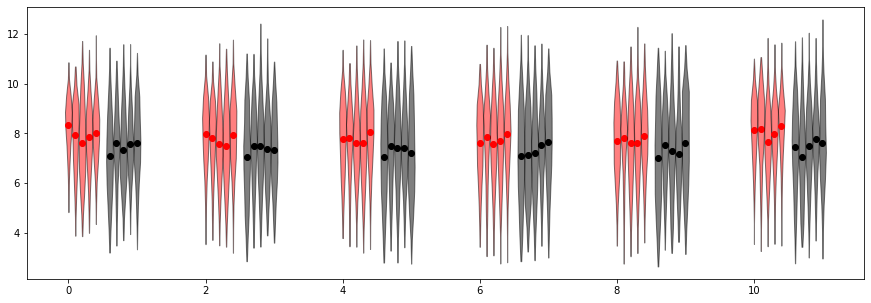

In [16]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_lap_stats,ctrl_lap_stats,'avg_std')
print(ko_means,ctrl_means)

In [12]:
print(ctrl_lap_stats[ctrl_mice[0]][0]['avg_std'].mean())
print(ctrl_lap_stats[ctrl_mice[1]][0]['avg_std'].mean())

7.929114136354405
8.103836015465367


In [22]:
ko_fw = {mouse:out_of_field_ratio(u.load_single_day(mouse,day=4), fam = True)[1] for mouse in ko_mice}
ctrl_fw = {mouse:out_of_field_ratio(u.load_single_day(mouse,day=4), fam = True)[1] for mouse in ctrl_mice}


# ko_oof = {mouse:out_of_field_ratio(u.load_single_day(mouse,day=3), fam = False) for mouse in ko_mice}
# ctrl_oof = {mouse:out_of_field_ratio(u.load_single_day(mouse,day=3), fam = False) for mouse in ctrl_mice}

# ko_oof = {mouse:out_of_field_ratio(u.single_mouse_concat_sessions(mouse,date_inds=np.arange(0,6)), fam = True)[0] for mouse in ko_mice}
# ctrl_oof = {mouse:out_of_field_ratio(u.single_mouse_concat_sessions(mouse,date_inds=np.arange(0,6)), fam = True)[0] for mouse in ctrl_mice}

{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel': -1, 

[1.2049189830736362, 1.2215833855401412, 1.2181517085806253, 1.1244306974289424, 1.3561290564536597] [1.38869317489851, 1.0996474010085269, 1.3340367448245023, 1.1868888902828716, 1.306090462002303]
-0.5904973451495082 0.5711572228643489


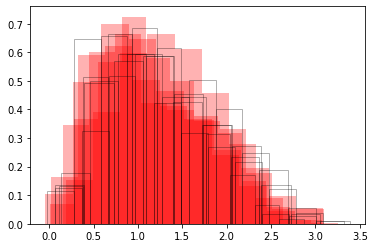

In [23]:
fig, ax = plt.subplots()
# edges = np.arange(0,21)
ko_fieldsize= []
for mouse, fw in ko_fw.items():
    ax.hist(fw, alpha=.3,color='red',density=True)
    ko_fieldsize.append(fw.mean(axis=0).mean())
ctrl_fieldsize = []
for mouse, fw in ctrl_fw.items():
    ax.hist(fw,alpha=.3,color='black',density=True,fill=False)
    ctrl_fieldsize.append(fw.mean(axis=0).mean())

print(ko_fieldsize, ctrl_fieldsize)
t,p = sp.stats.ttest_ind(ko_fieldsize,ctrl_fieldsize)
print(t,p)

-2.9954133642450413 0.017191455899189384


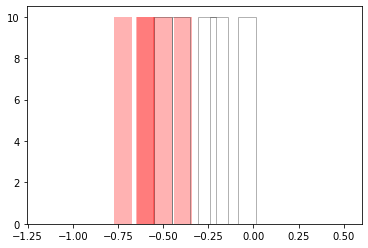

In [9]:
fig, ax = plt.subplots()
# edges = np.arange(0,21)
ko_fieldsize= []
for mouse, fw in ko_fw.items():
    ax.hist(fw.mean(axis=0), alpha=.3,color='red',density=True)
    ko_fieldsize.append(fw.mean(axis=0).mean())
ctrl_fieldsize = []
for mouse, fw in ctrl_fw.items():
    ax.hist(fw.mean(axis=0),alpha=.3,color='black',density=True,fill=False)
    ctrl_fieldsize.append(fw.mean(axis=0).mean())
    
t,p = sp.stats.ttest_ind(ko_fieldsize,ctrl_fieldsize)
print(t,p)

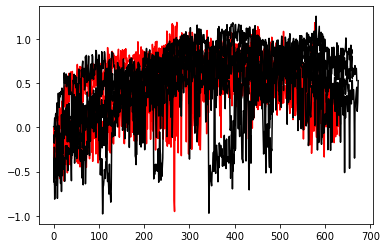

In [32]:
fig,ax = plt.subplots()
for mouse, oof_rat in ko_oof.items():
    ax.plot(oof_rat.mean(axis=-1),color='red')

for mouse, oof_rat in ctrl_oof.items():
    ax.plot(oof_rat.mean(axis=-1),color='black')

In [78]:
sess = u.load_single_day(ko_mice[4],day=3)
# sess = u.single_mouse_concat_sessions(ko_mice[0],date_inds = np.arange(0,2))
fam = True
if fam:
    cellmask, _ = place_cell_masks(sess)
    trialmask = sess.trial_info['LR']==-1*sess.novel_arm

else:
    _,cellmask = place_cell_masks(sess)
    trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
trial_mat[np.isnan(trial_mat)]=1E-5
trial_mat = trial_mat[trialmask,:,:]
trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)

avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)
avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)
print(avg_trial_mat_norm.shape)

inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
print(com.shape, std.shape)

avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

skewness = (np.power((inds-avg_com)/avg_std,3)*avg_trial_mat_norm).sum(axis=1)
print(skewness.shape)

{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel': -1, 'ravel_ind': 3}
(1, 30, 1384)
(49, 1, 1384) (49, 1, 1384)
(1, 1384)


(array([  2.,  12.,  48., 100., 300., 461., 286., 121.,  38.,  16.]),
 array([-2.51075178, -2.04419152, -1.57763126, -1.111071  , -0.64451074,
        -0.17795048,  0.28860977,  0.75517003,  1.22173029,  1.68829055,
         2.15485081]),
 <BarContainer object of 10 artists>)

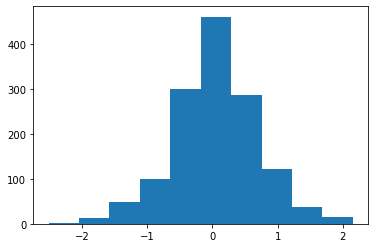

In [79]:
fig,ax = plt.subplots()
ax.hist(skewness.ravel())
# ax.plot(skewness.mean(axis=-1))

<ipython-input-95-d84c1b3dd47f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


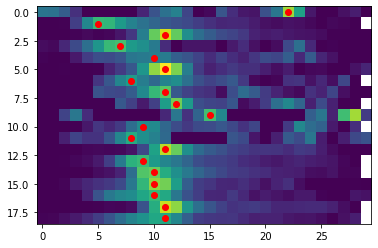

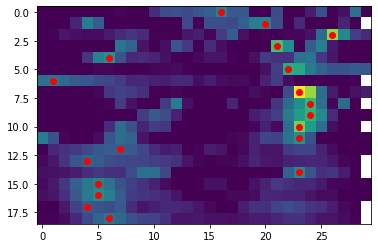

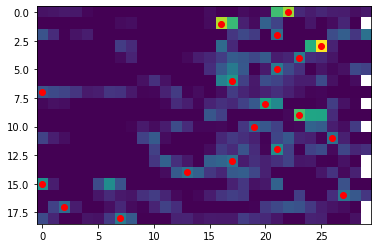

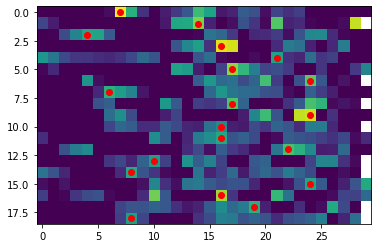

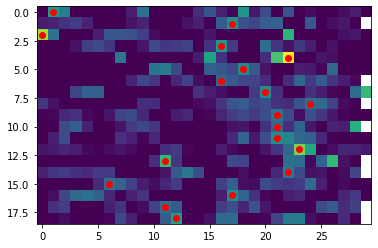

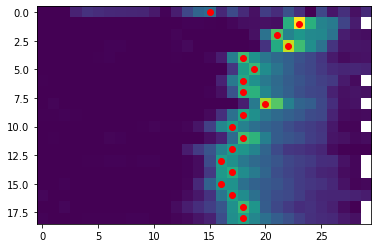

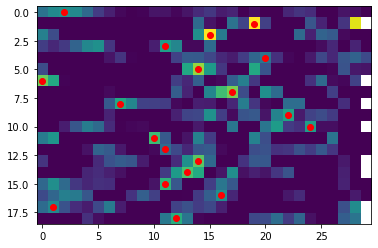

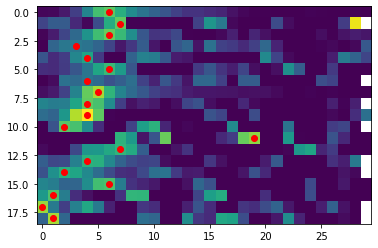

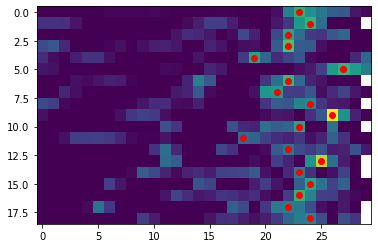

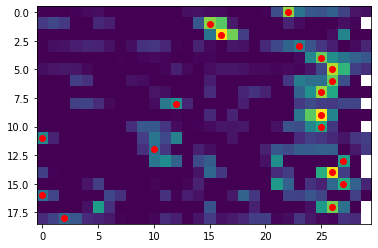

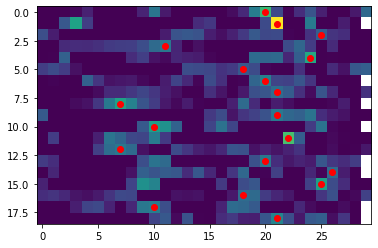

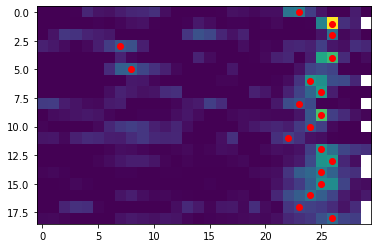

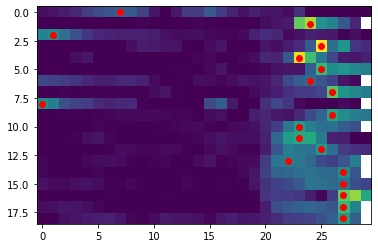

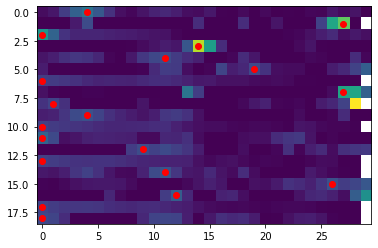

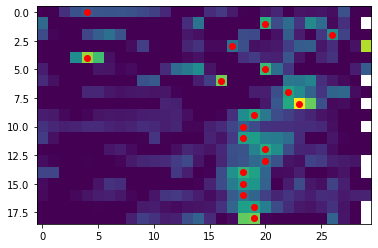

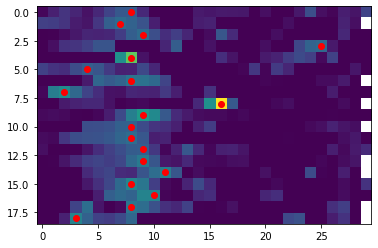

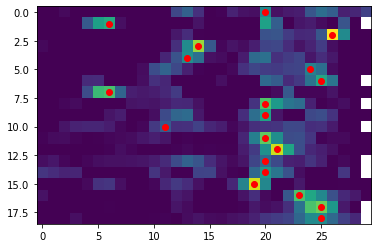

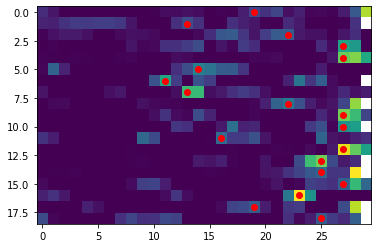

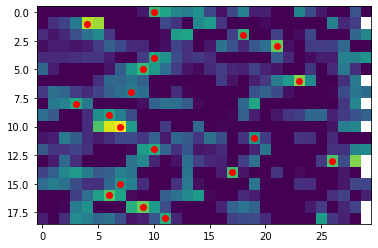

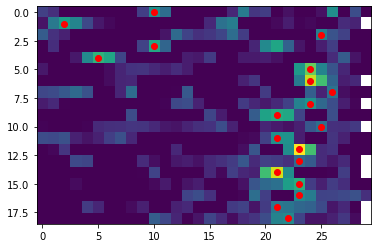

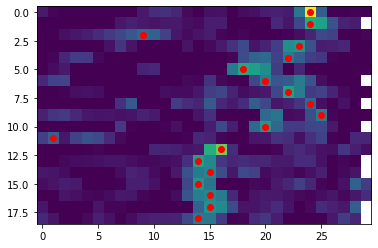

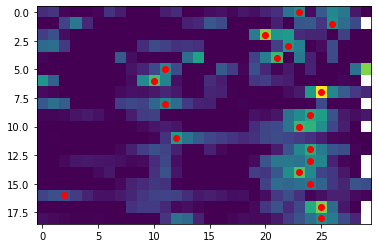

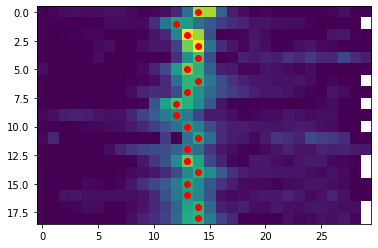

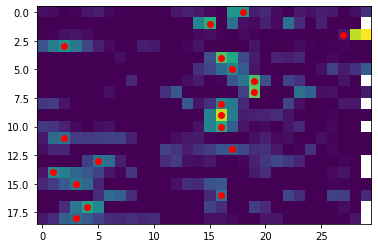

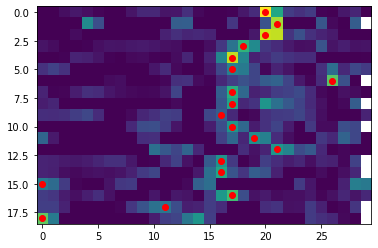

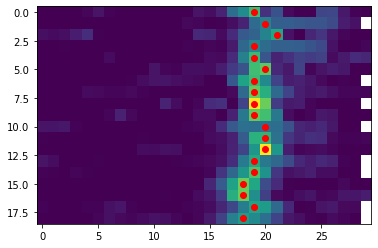

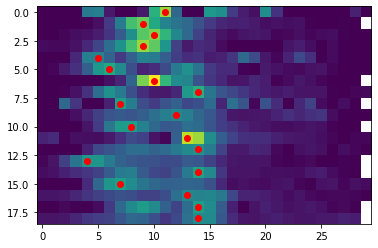

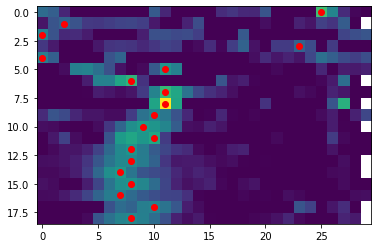

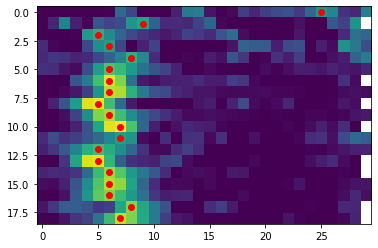

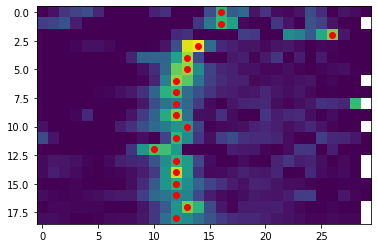

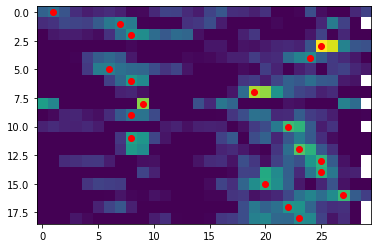

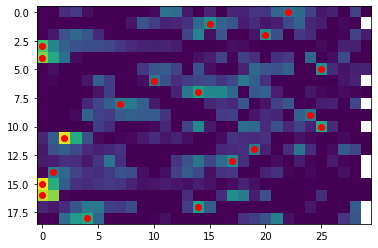

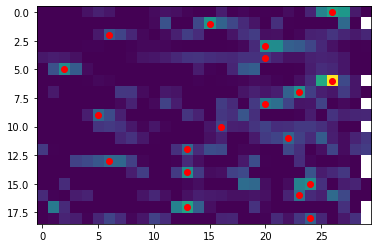

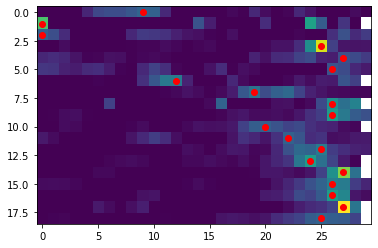

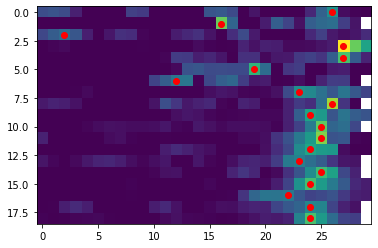

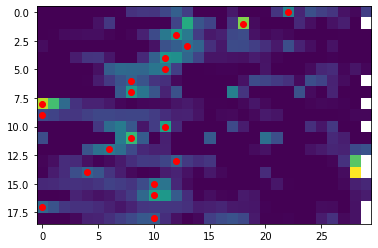

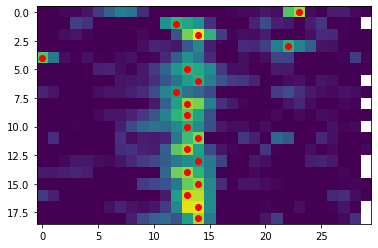

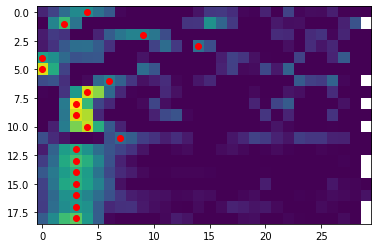

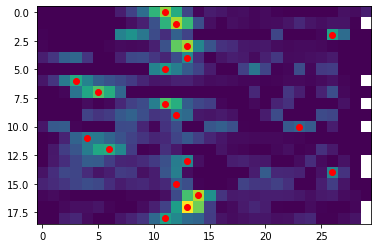

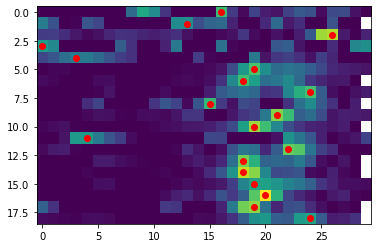

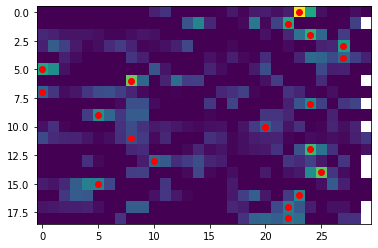

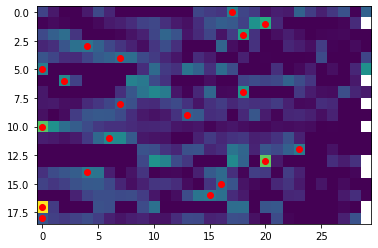

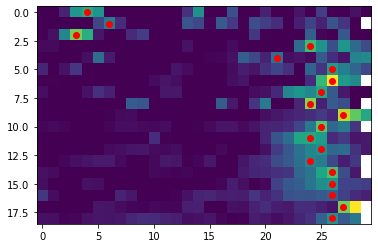

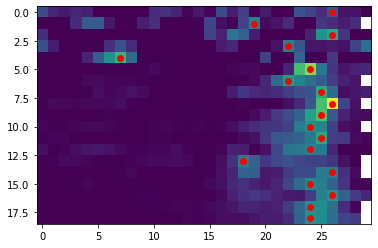

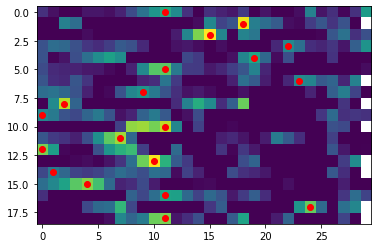

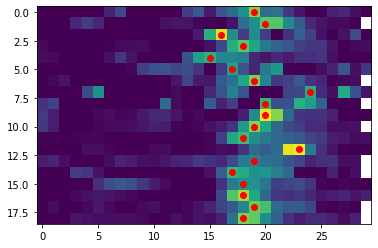

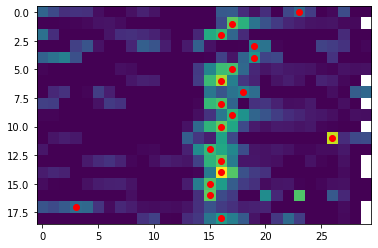

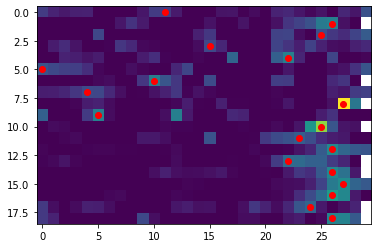

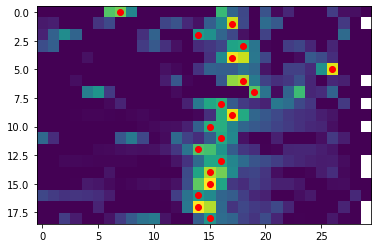

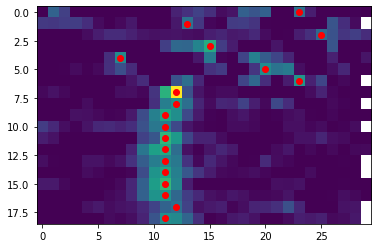

In [95]:
for cell in range(50):
    fig,ax = plt.subplots()
    tm = trial_mat_norm[:,:,cell]
    maxmask = np.zeros(tm.shape)
    
    
    ax.imshow(tm,aspect='auto')
    ax.scatter(np.argmax(tm[:,:-2],axis=1), np.arange(0,tm.shape[0]),color='red')
#     ax.imshow(maxmask,alpha=.3,aspect='auto',cmap='Reds')

<ipython-input-5-3b3c90ef42c8>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


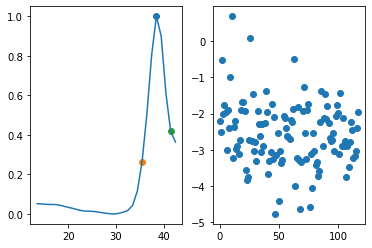

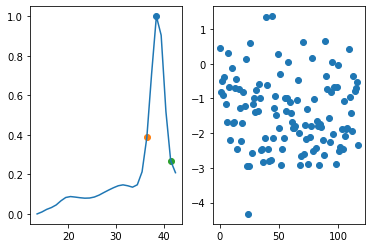

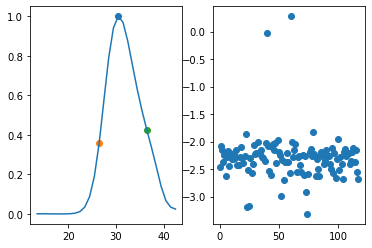

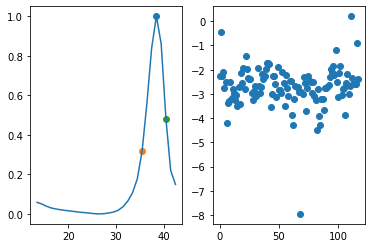

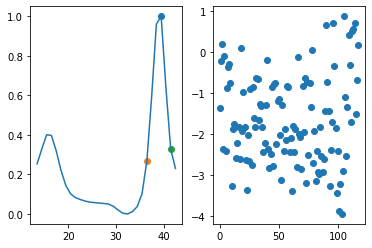

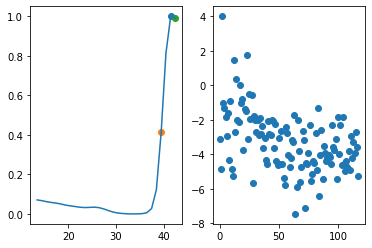

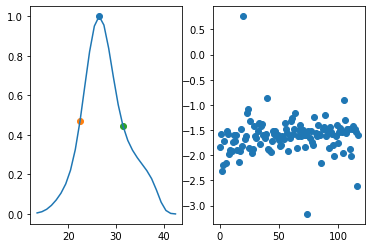

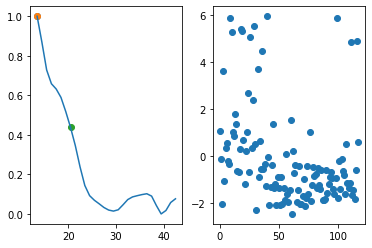

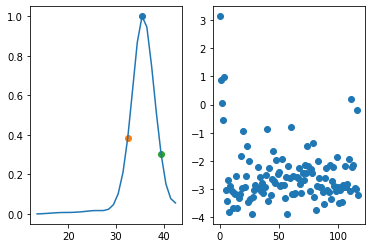

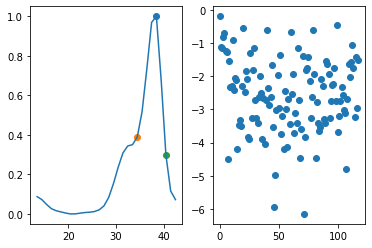

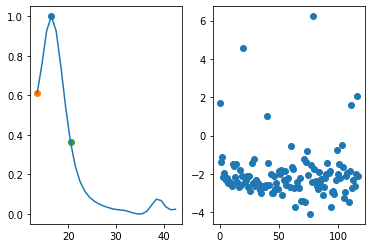

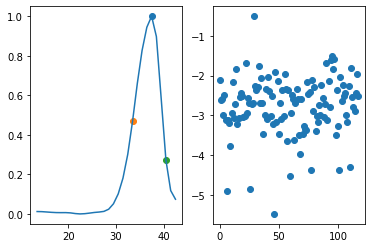

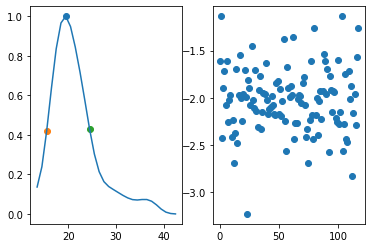

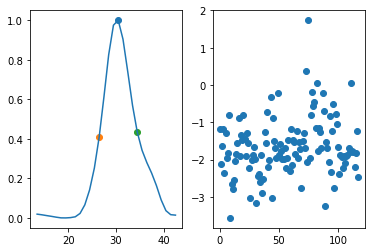

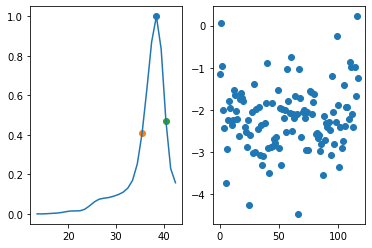

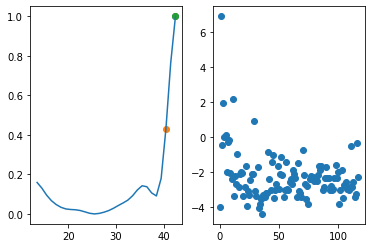

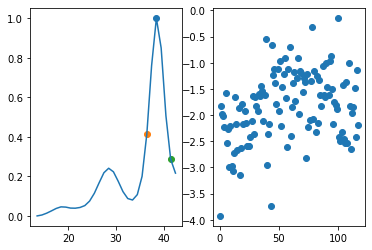

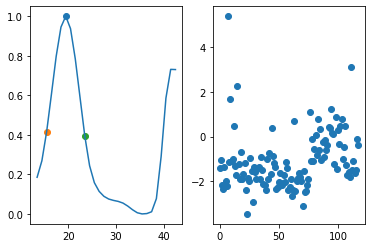

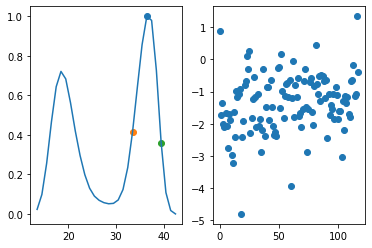

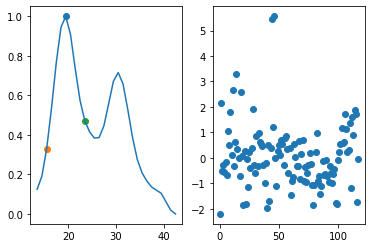

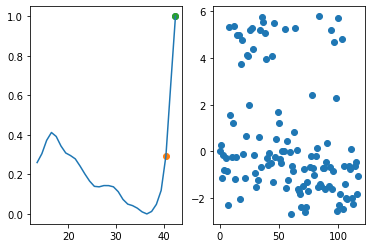

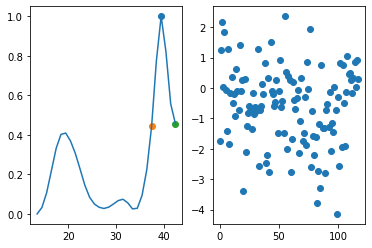

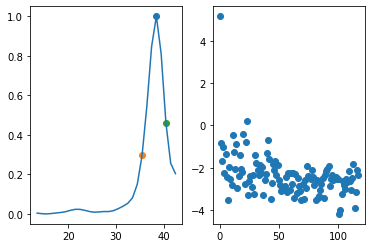

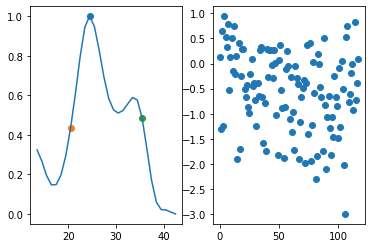

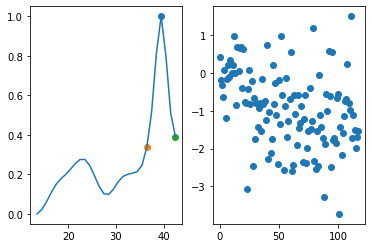

In [5]:
for cell in range(25):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(sess.trial_matrices['bin_centers'],norm_rate_map[:,cell])
    ax[0].scatter(sess.trial_matrices['bin_centers'][peak_inds[0,cell]], norm_rate_map[peak_inds[0,cell],cell])
    
    ax[0].scatter(sess.trial_matrices['bin_centers'][left_edge[cell]], norm_rate_map[left_edge[cell],cell])
    r_edge = np.minimum(29,right_edge[cell])
    ax[0].scatter(sess.trial_matrices['bin_centers'][r_edge], norm_rate_map[r_edge,cell])
    
    
    ax[1].scatter(np.arange(0,trial_mat.shape[0]),oof_rat[:,cell])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False]
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True 

<ipython-input-25-5b84f08ce5d1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


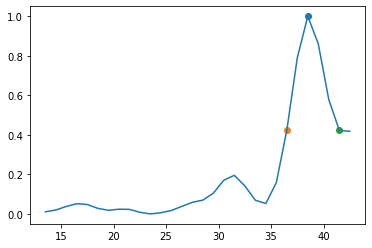

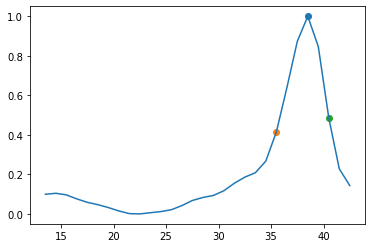

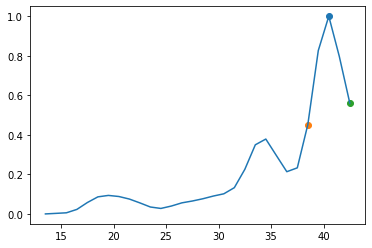

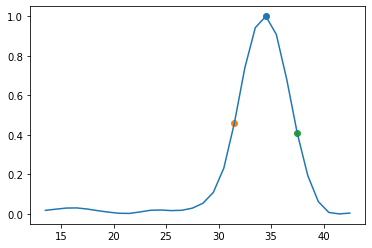

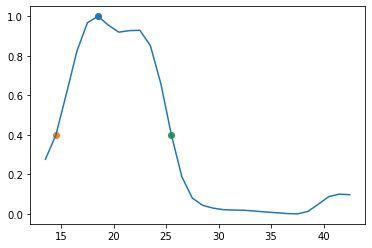

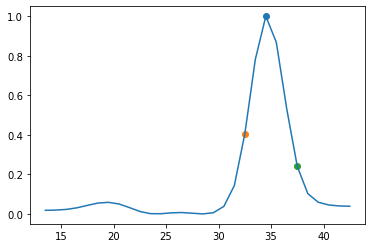

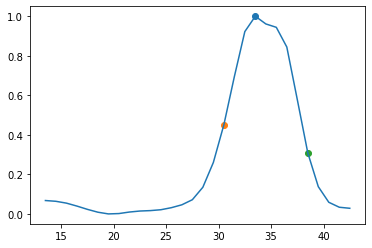

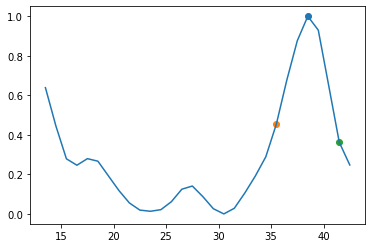

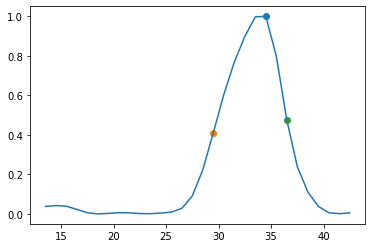

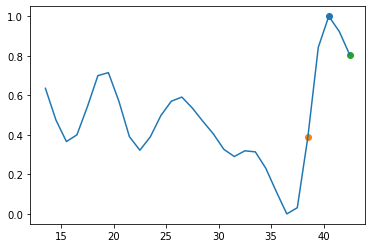

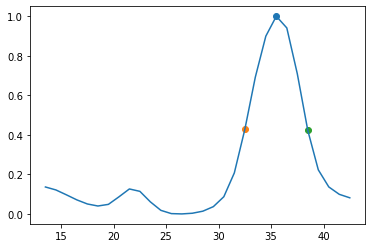

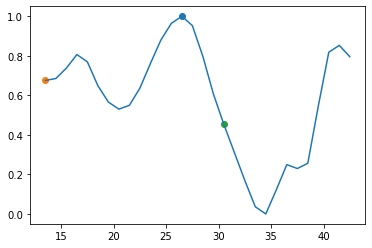

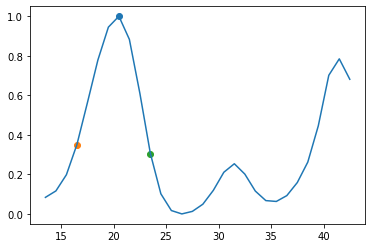

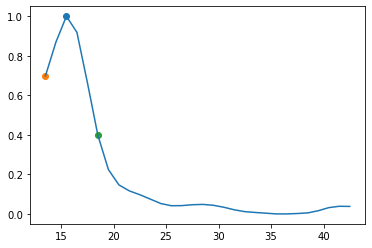

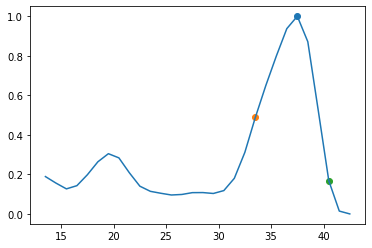

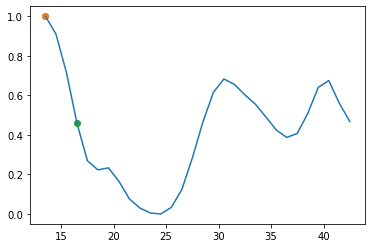

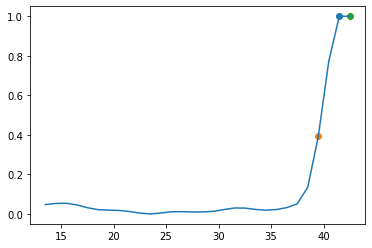

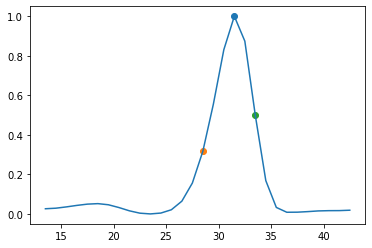

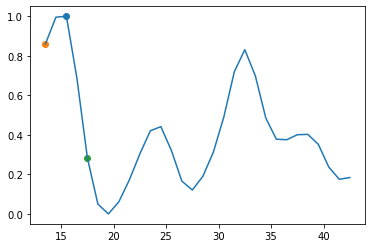

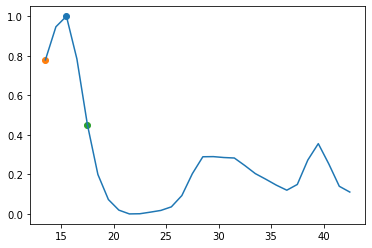

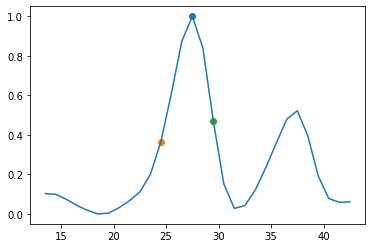

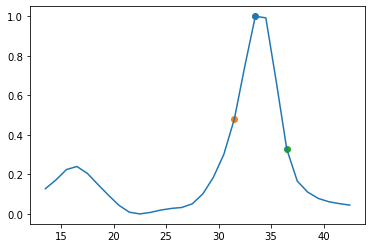

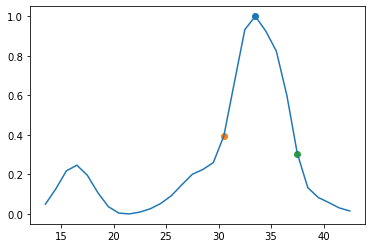

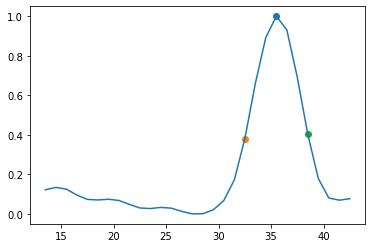

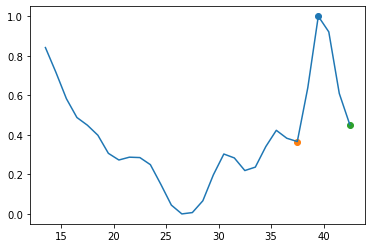

In [25]:
for cell in range(25):
    fig, ax = plt.subplots()
    ax.plot(sess.trial_matrices['bin_centers'],norm_rate_map[:,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][peak_inds[cell]], norm_rate_map[peak_inds[cell],cell])
    
    half_max = norm_rate_map[:,cell]<=.5
    left_mask = half_max*(np.arange(0,norm_rate_map.shape[0])<peak_inds[cell])
    print(left_mask)
    if left_mask.sum()>0:
        left_edge = np.argwhere(left_mask)[-1]
    else:
        left_edge = 0
        
    right_mask = half_max*(np.arange(0,norm_rate_map.shape[0])>peak_inds[cell])
    if right_mask.sum()>0:
        right_edge = np.argwhere(right_mask)[0]
    else:
        right_edge = avg_rate_map.shape[0]-1
    
    ax.scatter(sess.trial_matrices['bin_centers'][left_edge], norm_rate_map[left_edge,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][right_edge], norm_rate_map[right_edge,cell])

In [ ]:
# within-day 


# get familiar arm place cells


# find peak based on average

# define field as FWHM of peak

    # save width
    
# out of field normalized activity rate per trial

# spatial variance of firing rate